# Transfer learning
### VGG16

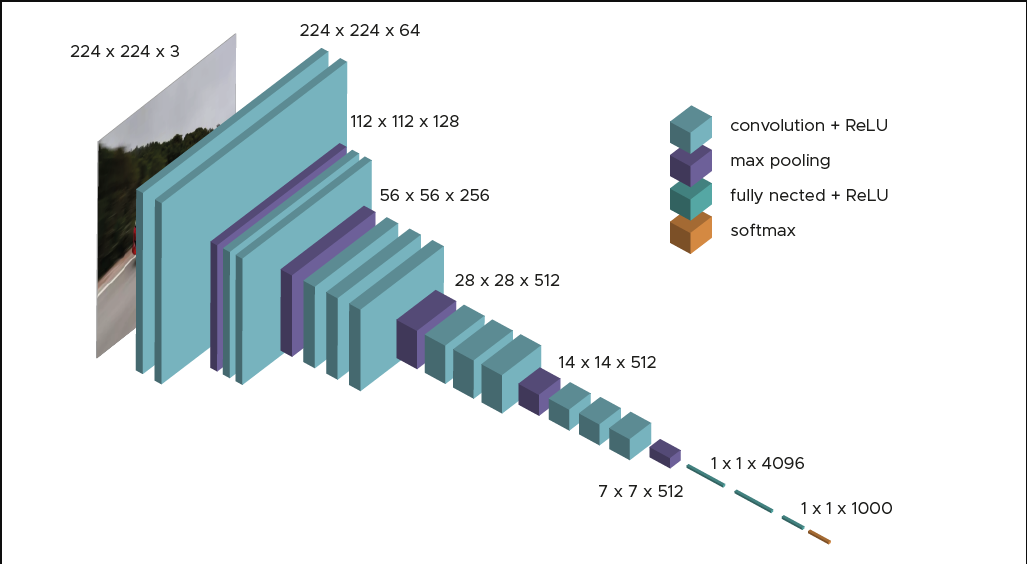

### Feature transformer
##### How to use VGG?

*   "Chop off the head"
*   Everything up to the second last layer is a state-of-the-art feature transformer
* Then add our own linear classifier on top and train it


#### Should I train the VGG weights?

* We call this "fine tuning"
* We could do a fine tuning to obtain better results, but it takes longer


In [36]:
import os
import glob
import matplotlib.pyplot as plt

Load dataset

In [5]:
from kaggle.api.kaggle_api_extended import KaggleApi

os.environ['KAGGLE_USERNAME'] = "xxxxxxx"                 #Manually input from kaggle
os.environ['KAGGLE_KEY'] = "xxxxxxxx"   #Manually input from kaggle

api = KaggleApi()
api.authenticate()

api.dataset_download_files('moltean/fruits', path="./Images/", unzip=True)
del api

In [ ]:
images_path = './Images/fruits-360-original-size/fruits-360-original-size/'

classes = os.listdir(images_path + 'Training')
classes

In [22]:
image_shape = [100,100]

training_images_paths = glob.glob(images_path + 'Training/' + '*/*.jpg')
validation_images_paths = glob.glob(images_path + 'Validation/' + '*/*.jpg')

Create VGG16 model

In [25]:
import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Lambda, Dense, Flatten
from tensorflow.keras.applications import VGG16

In [27]:
vgg16 = VGG16(input_shape = image_shape + [3], weights = 'imagenet', include_top = False)

#Disable training for existing weights
#we just want to train our layers
for layer in vgg16.layers:
  layer.trainable = False

"""model = Sequential([
    vgg16, 
    Flatten(),
    Dense(len(classes), activation = 'softmax')
])"""

x = Flatten()(vgg16.output)
preditction_layer = Dense(len(classes), activation = 'softmax')(x)

model = Model(inputs = vgg16.input, outputs = preditction_layer)

model.compile(loss = 'categorical_crossentropy', optimizer =  'rmsprop', metrics = ['accuracy'])
model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 100, 100, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 100, 100, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 100, 100, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 50, 50, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 50, 50, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 50, 50, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 25, 25, 128)       0   

  Image processing

In [117]:
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.vgg16 import preprocess_input

import cv2
import numpy as np

In [118]:
image_generator = ImageDataGenerator(
    rotation_range = 20,
    width_shift_range = 0.1,
    height_shift_range = 0.1,
    shear_range = 0.1,
    zoom_range = 0.2,
    horizontal_flip = True,
    vertical_flip = True,
    preprocessing_function = preprocess_input
)

Found 3110 images belonging to 24 classes.
{'apple_6': 0, 'apple_braeburn_1': 1, 'apple_crimson_snow_1': 2, 'apple_golden_1': 3, 'apple_golden_2': 4, 'apple_golden_3': 5, 'apple_granny_smith_1': 6, 'apple_hit_1': 7, 'apple_pink_lady_1': 8, 'apple_red_1': 9, 'apple_red_2': 10, 'apple_red_3': 11, 'apple_red_delicios_1': 12, 'apple_red_yellow_1': 13, 'apple_rotten_1': 14, 'cabbage_white_1': 15, 'carrot_1': 16, 'cucumber_1': 17, 'cucumber_3': 18, 'eggplant_violet_1': 19, 'pear_1': 20, 'pear_3': 21, 'zucchini_1': 22, 'zucchini_dark_1': 23}
min: -110.23998260498047, max: 151.06100463867188


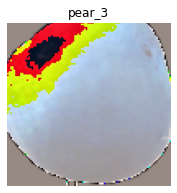

In [119]:
#Just to test our generator
Test_generator = image_generator.flow_from_directory(images_path + 'Test', 
                                                     target_size = image_shape)
print(Test_generator.class_indices)

for x,y in Test_generator:
  print("min: {}, max: {}".format(x[0].min(), x[0].max()))
  plt.imshow(np.array(x[0], dtype = 'uint8'))
  class_ = list(Test_generator.class_indices.keys())[list(Test_generator.class_indices.values()).index(np.argmax(y[0]))]
  plt.title(class_)
  plt.axis('off')
  break

Train model

In [120]:
Train_generator = image_generator.flow_from_directory(images_path + 'Training', 
                                                     target_size = image_shape)
Validation_generator = image_generator.flow_from_directory(images_path + 'Validation', 
                                                     target_size = image_shape)

Found 6231 images belonging to 24 classes.
Found 3114 images belonging to 24 classes.


In [121]:
batch_size = 64
epochs = 8

fitting = model.fit_generator(generator = Train_generator, 
                              validation_data = Validation_generator,
                              epochs = epochs,
                              steps_per_epoch = len(training_images_paths)//batch_size ,
                              validation_steps = len(validation_images_paths)//batch_size)

<ipython-input-121-f8cf46af4f81>:4: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  fitting = model.fit_generator(generator = Train_generator,


Epoch 1/8
97/97 [==============================] - 31s 322ms/step - loss: 0.3539 - accuracy: 0.9667 - val_loss: 0.3211 - val_accuracy: 0.9798
Epoch 2/8
97/97 [==============================] - 42s 433ms/step - loss: 0.3193 - accuracy: 0.9709 - val_loss: 0.2753 - val_accuracy: 0.9727
Epoch 3/8
97/97 [==============================] - 31s 323ms/step - loss: 0.3140 - accuracy: 0.9736 - val_loss: 0.5526 - val_accuracy: 0.9629
Epoch 4/8
97/97 [==============================] - 31s 319ms/step - loss: 0.2027 - accuracy: 0.9807 - val_loss: 0.1672 - val_accuracy: 0.9863
Epoch 5/8
97/97 [==============================] - 31s 325ms/step - loss: 0.2976 - accuracy: 0.9765 - val_loss: 0.2096 - val_accuracy: 0.9818
Epoch 6/8
97/97 [==============================] - 42s 433ms/step - loss: 0.2263 - accuracy: 0.9823 - val_loss: 0.3260 - val_accuracy: 0.9714
Epoch 7/8
97/97 [==============================] - 41s 421ms/step - loss: 0.2822 - accuracy: 0.9816 - val_loss: 0.1536 - val_accuracy: 0.9876
Epoch 

###Test the model
Confusion matrix

In [140]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

def get_confusion_matrix(data_path, N):
  # we need to see the data in the same order
  # for both predictions and targets
  print("Generating confusion matrix", N)
  predictions = []
  targets = []
  i = 0
  for x, y in image_generator.flow_from_directory(data_path, target_size=image_shape, 
                                                 shuffle=False, batch_size=batch_size * 2):

    p = model.predict(x, verbose = 0)
    p = np.argmax(p, axis=1)
    y = np.argmax(y, axis=1)

    predictions = np.concatenate((predictions, p))
    targets = np.concatenate((targets, y))

    if len(targets) >= N:
      break

    cm = confusion_matrix(targets, predictions)
  print("Generated conf maxtrix")
  return cm

labels = Test_generator.class_indices
labels = list(labels.keys())

Generating confusion matrix 6231
Found 6231 images belonging to 24 classes.
Generated conf maxtrix


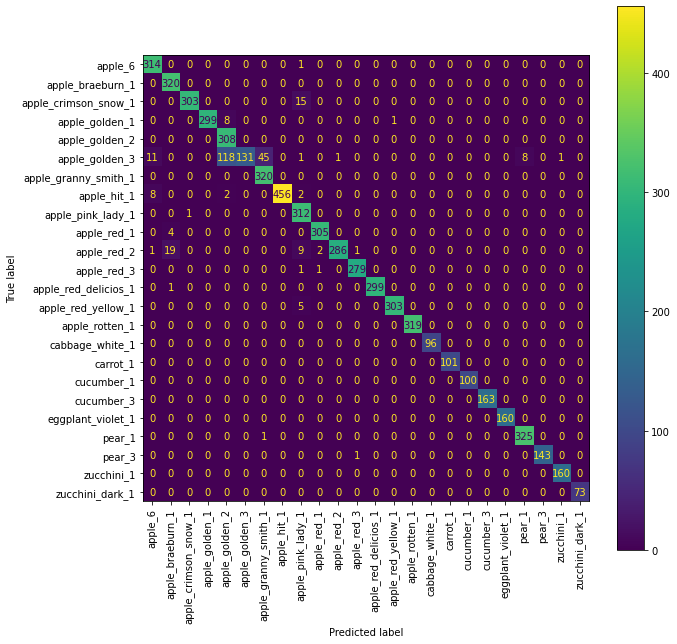

In [142]:
Training_conf_mx = get_confusion_matrix(images_path + 'Training', len(training_images_paths))
disp = ConfusionMatrixDisplay(Training_conf_mx, display_labels=labels)
disp.plot(xticks_rotation = 90) 
disp.figure_.set_size_inches(10,10)

Generating confusion matrix 3114
Found 3114 images belonging to 24 classes.
Generated conf maxtrix


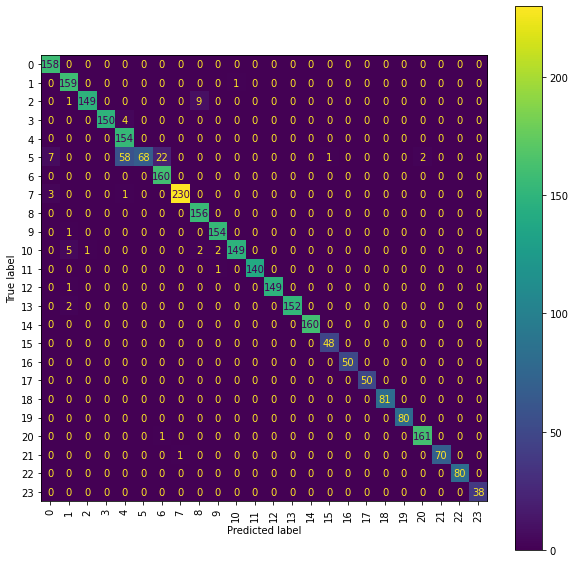

In [143]:
Validation_conf_mx = get_confusion_matrix(images_path + 'Validation', len(validation_images_paths))
disp = ConfusionMatrixDisplay(Validation_conf_mx)
disp.plot(xticks_rotation = 90) 
disp.figure_.set_size_inches(10,10)

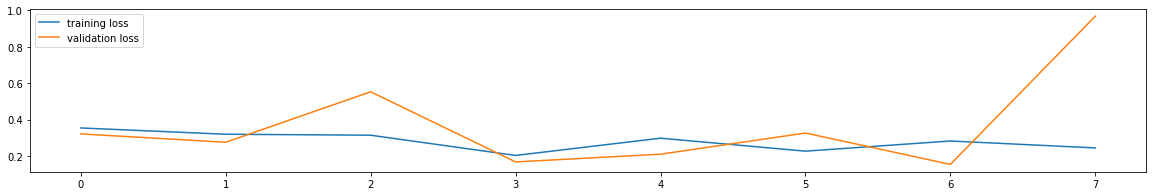

In [144]:
plt.plot(fitting.history['loss'], label = 'training loss')
plt.plot(fitting.history['val_loss'], label = 'validation loss')
plt.legend()

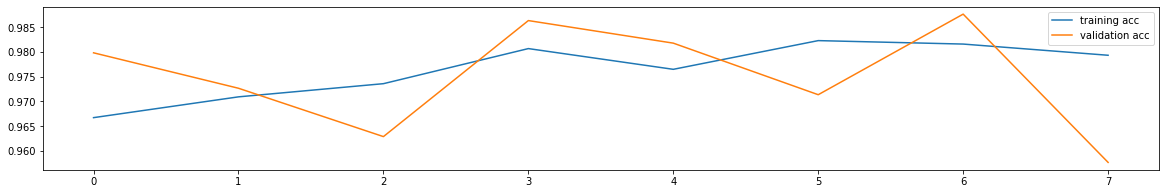

In [145]:
plt.plot(fitting.history['accuracy'], label = 'training acc')
plt.plot(fitting.history['val_accuracy'], label = 'validation acc')
plt.legend()